In [135]:
import os
import time
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm

### Set seeds for reproducibility

In [136]:
np.random.seed(42)
tf.random.set_seed(42)


### Check for GPU availability

In [137]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [138]:
lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

In [139]:
@dataclass
class Config:
    z_dim = 40*100  # Dimension of random noise
    batch_size = 64
    learning_rate_g = 0.0002
    learning_rate_d = 0.0002
    epochs = 200
    penalty_weight = 5

config = Config()

### Load and preprocess LOB data


In [140]:
file_path = "E:\DSA5204 Project\DSA5204-Group-9\lob\BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

print(f"The legnth for the dataframe is {len(df)}")

The legnth for the dataframe is 189760


In [141]:
df = df.dropna(subset=lob_features).sample(n=5000, random_state=42)

In [142]:
scaler = MinMaxScaler()
lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32) #(5000, 40)
lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)


In [143]:
for batch in lob_dataset.take(1):
    print(f"Dimension of lob_dataset: {batch.shape}")

Dimension of lob_dataset: (64, 40)


### Generator

In [144]:
class Generator(models.Model):
    """Simple Generator that transforms noise into a 40-dimensional feature vector with financial constraints"""
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim

        self.dense1 = layers.Dense(1024, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.leaky1 = layers.LeakyReLU(alpha=0.2)
        
        self.dense2 = layers.Dense(512, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.leaky2 = layers.LeakyReLU(alpha=0.2)
        
        self.dense3 = layers.Dense(256, use_bias=False)
        self.bn3 = layers.BatchNormalization()
        self.leaky3 = layers.LeakyReLU(alpha=0.2)

        self.dense4 = layers.Dense(128, use_bias=False)
        self.bn4 = layers.BatchNormalization()
        self.leaky4 = layers.LeakyReLU(alpha=0.2)

        self.dense5 = layers.Dense(64, use_bias=False)
        self.bn5 = layers.BatchNormalization()
        self.leaky5 = layers.LeakyReLU(alpha=0.2)

        self.output_layer = layers.Dense(40, activation='tanh')
    
    def apply_penalties(self, lob_output):
        penalties = tf.zeros_like(lob_output)

        # Ensure non-negative prices and quantities
        penalties += tf.nn.softplus(-lob_output)

        # Ensure bid prices are descending
        bid_prices = lob_output[:, :10]
        bid_diff = bid_prices[:, 1:] - bid_prices[:, :-1]
        bid_penalties = tf.nn.softplus(bid_diff)

        # Ensure ask prices are ascending
        ask_prices = lob_output[:, 20:30]
        ask_diff = ask_prices[:, 1:] - ask_prices[:, :-1]
        ask_penalties = tf.nn.softplus(-ask_diff)

        # Ensure bid and ask quantities are non-negative
        batch_size = tf.shape(lob_output)[0]

        # Create index tensors for updates
        bid_q_indices = tf.range(10, 20)  # Shape (10,)
        ask_q_indices = tf.range(30, 40)  # Shape (10,)

        # Expand batch dimension
        batch_indices = tf.range(batch_size)[:, None]  # Shape (batch_size, 1)

        bid_q_indices = tf.tile(bid_q_indices[None, :], [batch_size, 1])  # Shape (batch_size, 10)
        ask_q_indices = tf.tile(ask_q_indices[None, :], [batch_size, 1])  # Shape (batch_size, 10)

        bid_q_indices = tf.stack([tf.tile(batch_indices, [1, 10]), bid_q_indices], axis=-1)
        ask_q_indices = tf.stack([tf.tile(batch_indices, [1, 10]), ask_q_indices], axis=-1)

        bid_q_indices = tf.reshape(bid_q_indices, [-1, 2])
        ask_q_indices = tf.reshape(ask_q_indices, [-1, 2])

        bid_q_penalties = tf.reshape(tf.nn.softplus(-lob_output[:, 10:20]), [-1])
        ask_q_penalties = tf.reshape(tf.nn.softplus(-lob_output[:, 30:40]), [-1])

        penalties = tf.tensor_scatter_nd_add(penalties, bid_q_indices, bid_q_penalties)
        penalties = tf.tensor_scatter_nd_add(penalties, ask_q_indices, ask_q_penalties)

        # Ensure Best Bid - Best Ask is negative
        max_bid = tf.math.reduce_logsumexp(bid_prices, axis=1, keepdims=True)
        min_ask = -tf.math.reduce_logsumexp(-ask_prices, axis=1, keepdims=True)
        bid_ask_violation = tf.nn.softplus(min_ask - max_bid)

        return config.penalty_weight*penalties, bid_ask_violation + tf.reduce_sum(bid_penalties) + tf.reduce_sum(ask_penalties)

    def call(self, inputs, training=True):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.leaky1(x)
        
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.leaky2(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training=training)
        x = self.leaky3(x)
        
        x = self.dense4(x)
        x = self.bn4(x, training=training)
        x = self.leaky4(x)
        
        x = self.dense5(x)
        x = self.bn5(x, training=training)
        x = self.leaky5(x)
        
        lob_output = self.output_layer(x)
        penalties, bid_ask_violation = self.apply_penalties(lob_output)
        return lob_output, tf.reduce_sum(penalties, axis=1) + bid_ask_violation

### Minibatch Discriminator

In [145]:
# Minibatch Discrimination code
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        #Defines a trainable weight (self.kernel) of shape (input_dim, num_kernels, dim_per_kernel)
        self.input_dim = input_shape[1] #Stores the number of features in the input tensor.
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel) #Shape of the kernel tensor
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        #Computes a projection of inputs using self.kernel.
        #If inputs has shape (batch_size, input_dim),
        #And kernel has shape (input_dim, num_kernels, dim_per_kernel),
        #Then activation will have shape (batch_size, num_kernels, dim_per_kernel).
        #Got from dot product.
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])
        
        #Expands dimensions to compare all batch samples.
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        diff = expanded_act - transposed_act #
        abs_diff = tf.reduce_sum(tf.abs(diff), 2) #Computes the absolute differences between all pairs of samples.

        #Apply mask to avoid comparing a sample with itself.
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size) 
        #Creates an identity matrix (tf.eye(batch_size)), which has 1s on the diagonal and subtracts it from 1.0. Ensures that the diagonal is 0.
        mask = tf.expand_dims(mask, 1)

        #Expands dimensions to match abs_diff.
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        exp = tf.exp(-abs_diff) * mask
        minibatch_features = tf.reduce_sum(exp, 2)

        return tf.concat([inputs, minibatch_features], axis=1)

The final shape is (batch_size, input_dim + num_kernels).

### Discriminator

No batch normalization for discriminator as BatchNorm normalizes across the batch, which may leak information between examples.

In [146]:
class Discriminator(models.Model):
    """Simple Discriminator for classifying real vs fake feature vectors with financial constraints"""
    def __init__(self, config, use_minibatch_discrimination=False):
        super(Discriminator, self).__init__()
        self.config = config
        self.use_minibatch_discrimination = use_minibatch_discrimination  # Store the flag
        
        self.dense1 = layers.Dense(512, input_shape=(40,))
        self.leaky1 = layers.LeakyReLU(alpha=0.2)
        
        self.dense2 = layers.Dense(256)
        self.leaky2 = layers.LeakyReLU(alpha=0.2)
        
        # Add Minibatch Discrimination layer
        if use_minibatch_discrimination:
             self.minibatch_layer = MinibatchDiscrimination(num_kernels=100, dim_per_kernel=5)
             
        self.dense3 = layers.Dense(128)
        self.leaky3 = layers.LeakyReLU(alpha=0.2)
        
        self.dense4 = layers.Dense(64)
        self.leaky4 = layers.LeakyReLU(alpha=0.2)
        
        self.output_layer = layers.Dense(1)
    
    def apply_penalties(self, lob_output):
        penalties = tf.zeros_like(lob_output)

        # Ensure non-negative prices and quantities
        penalties += tf.nn.softplus(-lob_output)

        # Ensure bid prices are descending
        bid_prices = lob_output[:, :10]
        bid_diff = bid_prices[:, 1:] - bid_prices[:, :-1]
        bid_penalties = tf.nn.softplus(bid_diff)

        # Ensure ask prices are ascending
        ask_prices = lob_output[:, 20:30]
        ask_diff = ask_prices[:, 1:] - ask_prices[:, :-1]
        ask_penalties = tf.nn.softplus(-ask_diff)

        # Ensure bid and ask quantities are non-negative
        batch_size = tf.shape(lob_output)[0]

        # Create index tensors for updates
        bid_q_indices = tf.range(10, 20)  # Shape (10,)
        ask_q_indices = tf.range(30, 40)  # Shape (10,)

        # Expand batch dimension
        batch_indices = tf.range(batch_size)[:, None]  # Shape (batch_size, 1)

        bid_q_indices = tf.tile(bid_q_indices[None, :], [batch_size, 1])  # Shape (batch_size, 10)
        ask_q_indices = tf.tile(ask_q_indices[None, :], [batch_size, 1])  # Shape (batch_size, 10)

        bid_q_indices = tf.stack([tf.tile(batch_indices, [1, 10]), bid_q_indices], axis=-1)
        ask_q_indices = tf.stack([tf.tile(batch_indices, [1, 10]), ask_q_indices], axis=-1)

        bid_q_indices = tf.reshape(bid_q_indices, [-1, 2])
        ask_q_indices = tf.reshape(ask_q_indices, [-1, 2])

        bid_q_penalties = tf.reshape(tf.nn.softplus(-lob_output[:, 10:20]), [-1])
        ask_q_penalties = tf.reshape(tf.nn.softplus(-lob_output[:, 30:40]), [-1])

        penalties = tf.tensor_scatter_nd_add(penalties, bid_q_indices, bid_q_penalties)
        penalties = tf.tensor_scatter_nd_add(penalties, ask_q_indices, ask_q_penalties)

        # Ensure Best Bid - Best Ask is negative
        max_bid = tf.math.reduce_logsumexp(bid_prices, axis=1, keepdims=True)
        min_ask = -tf.math.reduce_logsumexp(-ask_prices, axis=1, keepdims=True)
        bid_ask_violation = tf.nn.softplus(min_ask - max_bid)
        return self.config.penalty_weight*penalties, bid_ask_violation + tf.reduce_sum(bid_penalties) + tf.reduce_sum(ask_penalties)
    
    def call(self, inputs, training=True, return_features=False):
        
        penalties, bid_ask_violation = self.apply_penalties(inputs)
        
        x = self.dense1(inputs)
        x = self.leaky1(x)
        
        x = self.dense2(x)
        x = self.leaky2(x)
        
        # Apply minibatch discrimination if enabled
        if self.use_minibatch_discrimination:
            x = self.minibatch_layer(x)
        x = self.dense3(x)
        x = self.leaky3(x)
        
        x = self.dense4(x)
        x = self.leaky4(x)
        
        output = self.output_layer(x)
        
        if return_features:
            total_penalty = tf.reduce_sum(penalties, axis=1) + bid_ask_violation
            return output, features, total_penalty
        return output

In [147]:
class SimpleGAN:
    """Simplest GAN with Financial Constraints using a Generator and Discriminator.
    
    Optionally enables minibatch discrimination in the discriminator.
    """
    def __init__(self, config, use_minibatch_discrimination=False):
        self.config = config
        
        # Instantiate the generator and discriminator with the minibatch option
        self.generator = Generator(config)
        self.discriminator = Discriminator(config, use_minibatch_discrimination=use_minibatch_discrimination)
        
        self.gen_optimizer = tf.keras.optimizers.Adam(config.learning_rate_g)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.learning_rate_d)
        
        self.fixed_noise = tf.random.normal([16, config.z_dim])

    def generator_loss(self, fake_output, fake_penalties):
        # Generator adversarial loss: try to fool the discriminator
        target = tf.ones_like(fake_output)
        adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(target, fake_output, from_logits=True))
        # Total loss includes adversarial loss and financial penalties
        return adv_loss + tf.reduce_mean(fake_penalties)

    def discriminator_loss(self, real_output, fake_output):
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)
        real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True))
        fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True))
        return real_loss + fake_loss
    
    @tf.function
    def train_step(self, real_matrices):
        batch_size = tf.shape(real_matrices)[0]
        noise = tf.random.normal([batch_size, self.config.z_dim])
        
        # Update discriminator
        with tf.GradientTape() as disc_tape:
            fake_matrices, fake_penalties = self.generator(noise, training=True)
            real_output = self.discriminator(real_matrices, training=True)
            fake_output = self.discriminator(fake_matrices, training=True)
            disc_loss = self.discriminator_loss(real_output, fake_output)
        
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        
        # Update generator
        with tf.GradientTape() as gen_tape:
            fake_matrices, fake_penalties = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_matrices, training=True)
            gen_loss = self.generator_loss(fake_output, fake_penalties)
        
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for batch in dataset:
                metrics = self.train_step(batch)
            print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {metrics['gen_loss']:.4f}, Discriminator Loss: {metrics['disc_loss']:.4f}")


### Reasonability Check functions:

In [148]:
def compute_faulty_rate(lob_tensor):
    """Calculates the faulty rate for synthetic LOB data using TensorFlow tensors."""
    
    bid_prices = lob_tensor[:, :10]  # First 10 columns are bid prices
    ask_prices = lob_tensor[:, 20:30]  # Columns 20-30 are ask prices
    bid_quantities = lob_tensor[:, 10:20]  # Columns 10-20 are bid quantities
    ask_quantities = lob_tensor[:, 30:40]  # Columns 30-40 are ask quantities

    faulty_count = tf.zeros(1, dtype=tf.float32)  # Initialize faulty count

    # 1. Ensure best bid price < best ask price (b0p < a0p)
    max_bid = tf.reduce_max(bid_prices, axis=1)  # Get the highest bid
    min_ask = tf.reduce_min(ask_prices, axis=1)  # Get the lowest ask
    faulty_count += tf.reduce_sum(tf.cast(max_bid >= min_ask, tf.float32))  # Count violations

    # 2. Bid prices should be in descending order (b0p > b1p > ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(bid_prices, axis=1) >= 0, tf.float32))

    # 3. Ask prices should be in ascending order (a0p < a1p < ...)
    faulty_count += tf.reduce_sum(tf.cast(tf.experimental.numpy.diff(ask_prices, axis=1) <= 0, tf.float32))

    # 4. Bid and ask quantities should be non-negative
    faulty_count += tf.reduce_sum(tf.cast(bid_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_prices < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_prices < 0, tf.float32))

    # Compute faulty rate as a percentage of all elements
    total_elements = tf.size(lob_tensor, out_type=tf.float32)
    faulty_rate = faulty_count / total_elements  # Returns a TensorFlow tensor

    return faulty_rate.numpy()  # Convert to NumPy for further processing


def plot_order_book_scatter(lob_sample):
    """Scatter plot of a single LOB snapshot with price vs. quantity and level labels."""

    # Extract bid and ask prices and sizes
    bid_prices = np.array(lob_sample[:10])
    bid_sizes = np.array(lob_sample[10:20])
    ask_prices = np.array(lob_sample[20:30])
    ask_sizes = np.array(lob_sample[30:40])

    # Remove negative or zero values to ensure valid plotting
    valid_bids = bid_sizes > 0
    valid_asks = ask_sizes > 0
    bid_prices, bid_sizes = bid_prices[valid_bids], bid_sizes[valid_bids]
    ask_prices, ask_sizes = ask_prices[valid_asks], ask_sizes[valid_asks]

    plt.figure(figsize=(8, 5))

    # Scatter plot for bids and asks
    plt.scatter(bid_sizes, bid_prices, color='blue', label="Bids", alpha=0.6)
    plt.scatter(ask_sizes, ask_prices, color='red', label="Asks", alpha=0.6)

    # Annotate each price level with its index
    for i, (q, p) in enumerate(zip(bid_sizes, bid_prices)):
        plt.annotate(f"b{i}", (q, p), fontsize=10, color='blue', ha="right")
    
    for i, (q, p) in enumerate(zip(ask_sizes, ask_prices)):
        plt.annotate(f"a{i}", (q, p), fontsize=10, color='red', ha="left")

    # Adjust x-axis and y-axis dynamically
    max_quantity = max(np.max(bid_sizes) if len(bid_sizes) > 0 else 0,
                       np.max(ask_sizes) if len(ask_sizes) > 0 else 0) * 1.1
    min_price = min(np.min(bid_prices) if len(bid_prices) > 0 else np.inf,
                    np.min(ask_prices) if len(ask_prices) > 0 else np.inf) /1.1
    max_price = max(np.max(bid_prices) if len(bid_prices) > 0 else -np.inf,
                    np.max(ask_prices) if len(ask_prices) > 0 else -np.inf) *1.1

    plt.xlim(0, max_quantity)
    plt.ylim(min_price, max_price)

    plt.xlabel("Quantity")
    plt.ylabel("Price")
    plt.title("LOB Scatter Plot (Price vs. Quantity)")

    plt.legend()
    plt.grid(True)
    plt.show()

### Train normal

In [149]:
np.random.seed(42)
tf.random.set_seed(42)

gan = SimpleGAN(config, use_minibatch_discrimination=False)
gan.train(lob_dataset, config.epochs)

noise = tf.random.normal([100, config.z_dim])
generated_samples, _ = gan.generator(noise, training=False)  # Ignore the penalties
generated_samples = generated_samples.numpy()
# Convert back to original scale
generated_samples = scaler.inverse_transform(generated_samples.reshape(100, -1))

Epoch 1/200 - Generator Loss: 302.1961, Discriminator Loss: 0.0053
Epoch 2/200 - Generator Loss: 278.2332, Discriminator Loss: 0.0006
Epoch 3/200 - Generator Loss: 253.7778, Discriminator Loss: 0.0000
Epoch 4/200 - Generator Loss: 240.6006, Discriminator Loss: 0.0001
Epoch 5/200 - Generator Loss: 234.0523, Discriminator Loss: 0.0261
Epoch 6/200 - Generator Loss: 233.9632, Discriminator Loss: 0.0000
Epoch 7/200 - Generator Loss: 231.9394, Discriminator Loss: 0.0000
Epoch 8/200 - Generator Loss: 231.9823, Discriminator Loss: 0.0000
Epoch 9/200 - Generator Loss: 228.4144, Discriminator Loss: 0.0000
Epoch 10/200 - Generator Loss: 227.2898, Discriminator Loss: 0.0000
Epoch 11/200 - Generator Loss: 227.7030, Discriminator Loss: 0.0000
Epoch 12/200 - Generator Loss: 226.6552, Discriminator Loss: 0.0000
Epoch 13/200 - Generator Loss: 226.5094, Discriminator Loss: 0.0000
Epoch 14/200 - Generator Loss: 225.8715, Discriminator Loss: 0.0000
Epoch 15/200 - Generator Loss: 225.3155, Discriminator Lo

#### Reasonability Check (Normal)

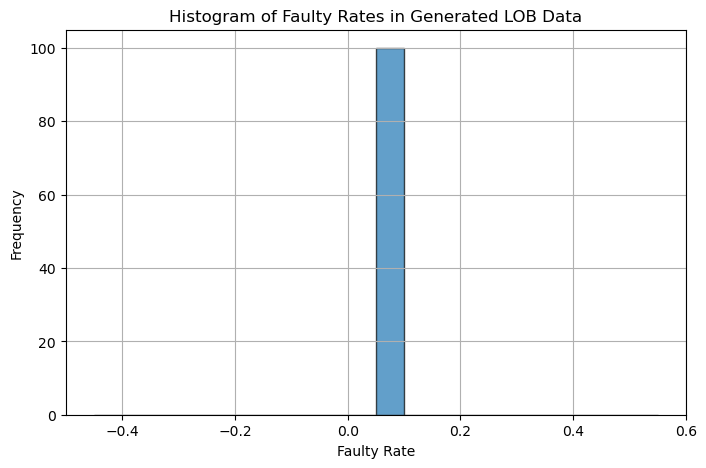

first sample saved to 'single_generated_lob.csv'


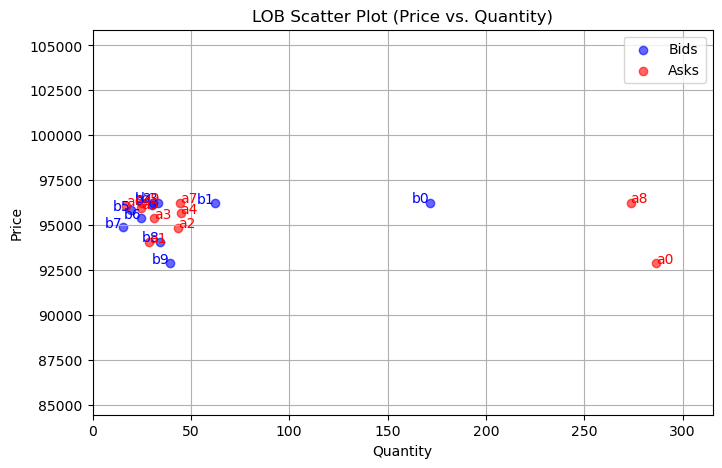

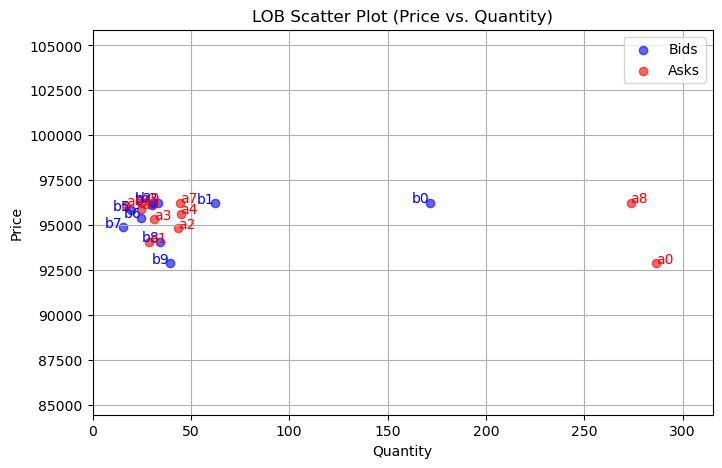

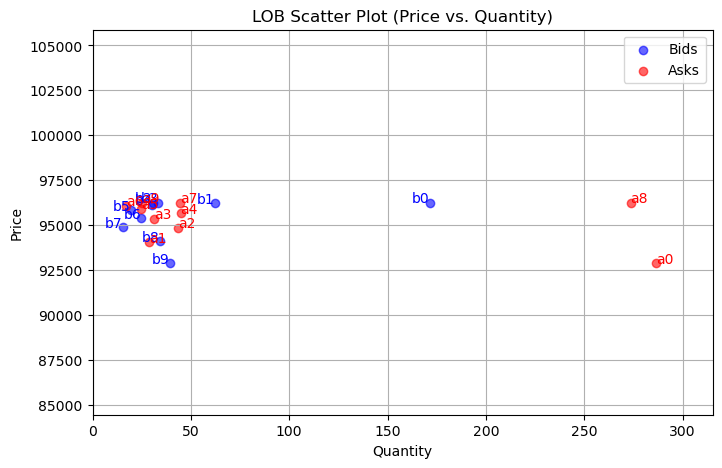

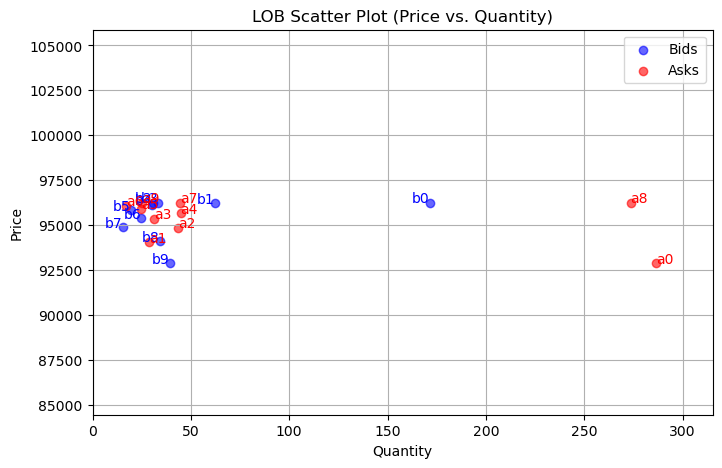

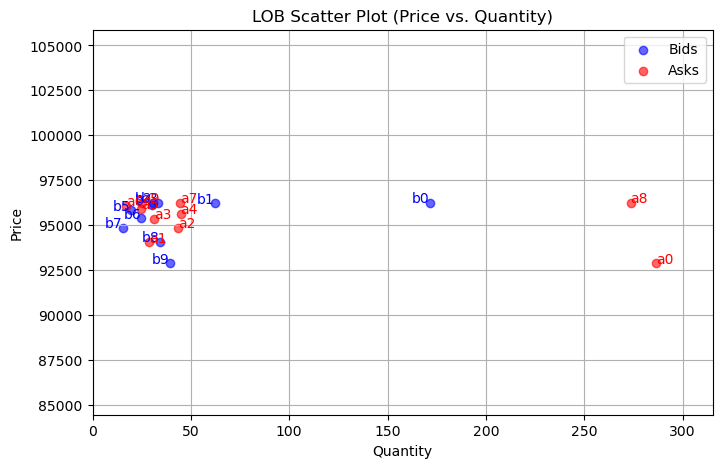

In [150]:
faulty_rates = np.array([compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)) for sample in generated_samples])

# Plot histogram of faulty rates
plt.figure(figsize=(8, 5))
plt.hist(faulty_rates, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Faulty Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Faulty Rates in Generated LOB Data")
plt.grid(True)
plt.show()

# Save to CSV
single_lob_sample = generated_samples[0]  # Choose the first generated sample

# Define column names for LOB structure
lob_columns = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

# Convert to DataFrame
df_single_lob = pd.DataFrame([single_lob_sample], columns=lob_columns)

# Save as CSV
df_single_lob.to_csv("single_generated_lob.csv", index=False)
print("first sample saved to 'single_generated_lob.csv'")

for i in range(5):
    plot_order_book_scatter(generated_samples[i])

### Testing Minibatch Discriminator

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

gan_mindis = SimpleGAN(config, use_minibatch_discrimination=True)
gan_mindis.train(lob_dataset, config.epochs)

noise = tf.random.normal([100, config.z_dim])
generated_samples_mindis, _ = gan_mindis.generator(noise, training=False)  # Ignore the penalties
generated_samples_mindis = generated_samples_mindis.numpy()
# Convert back to original scale
generated_samples_mindis = scaler.inverse_transform(generated_samples_mindis.reshape(100, -1))

Epoch 1/200 - Generator Loss: 284.7095, Discriminator Loss: 0.4449
Epoch 2/200 - Generator Loss: 257.5676, Discriminator Loss: 0.5115
Epoch 3/200 - Generator Loss: 236.9955, Discriminator Loss: 0.4986
Epoch 4/200 - Generator Loss: 226.1090, Discriminator Loss: 0.4624
Epoch 5/200 - Generator Loss: 218.1294, Discriminator Loss: 0.4129
Epoch 6/200 - Generator Loss: 211.5147, Discriminator Loss: 0.3701
Epoch 7/200 - Generator Loss: 208.4798, Discriminator Loss: 0.3059
Epoch 8/200 - Generator Loss: 207.3821, Discriminator Loss: 0.2560
Epoch 9/200 - Generator Loss: 207.0988, Discriminator Loss: 0.2206
Epoch 10/200 - Generator Loss: 205.8911, Discriminator Loss: 0.1929
Epoch 11/200 - Generator Loss: 205.6157, Discriminator Loss: 0.1679
Epoch 12/200 - Generator Loss: 205.4470, Discriminator Loss: 0.1487
Epoch 13/200 - Generator Loss: 204.9963, Discriminator Loss: 0.1316
Epoch 14/200 - Generator Loss: 205.0073, Discriminator Loss: 0.1153
Epoch 15/200 - Generator Loss: 205.1580, Discriminator Lo

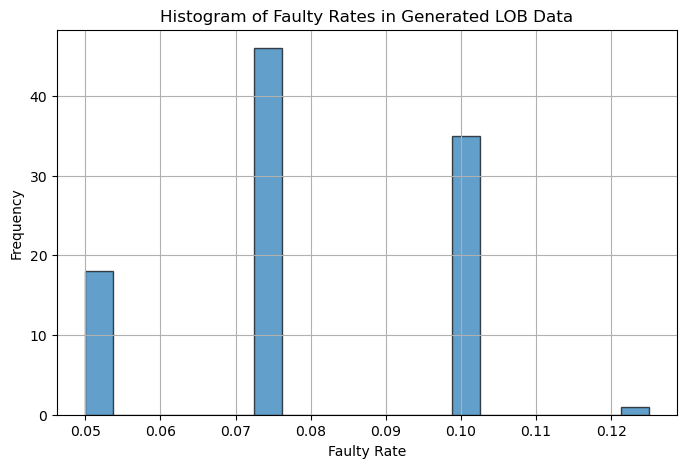

first sample saved to 'single_generated_lob.csv'


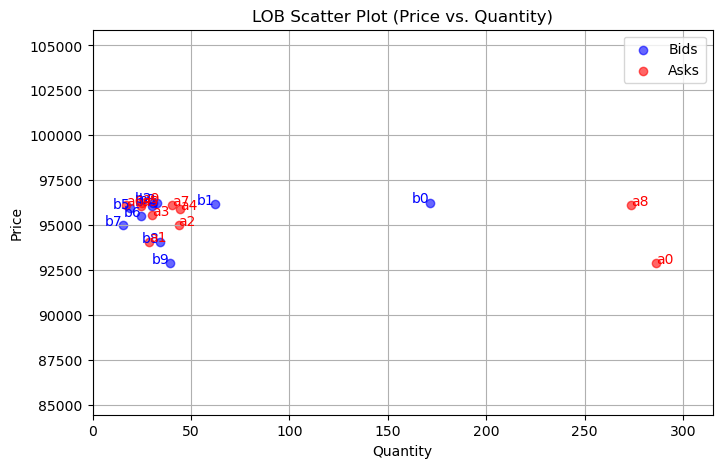

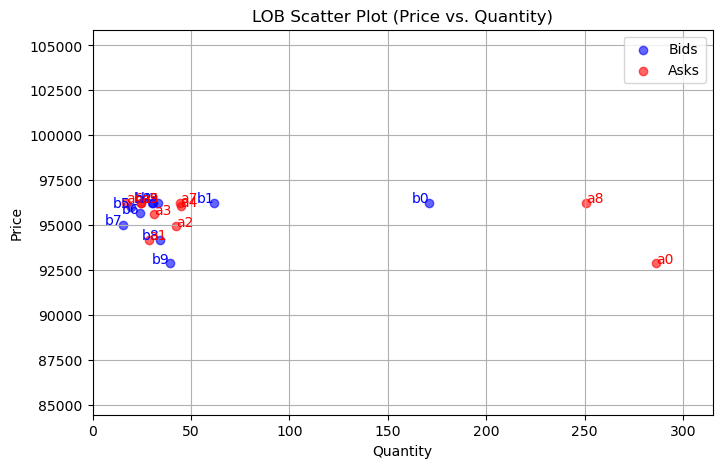

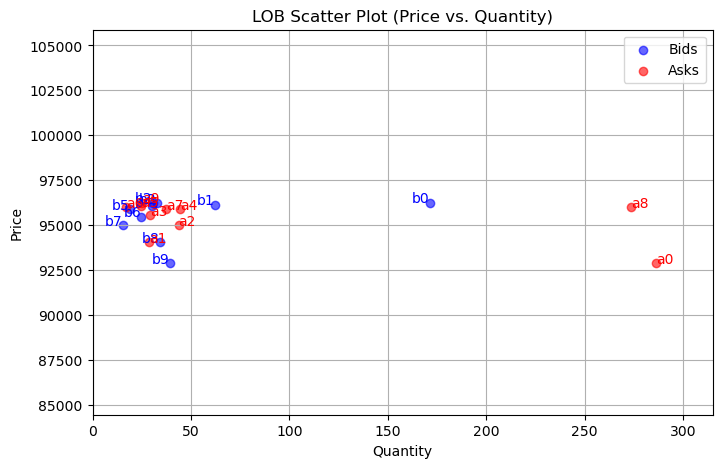

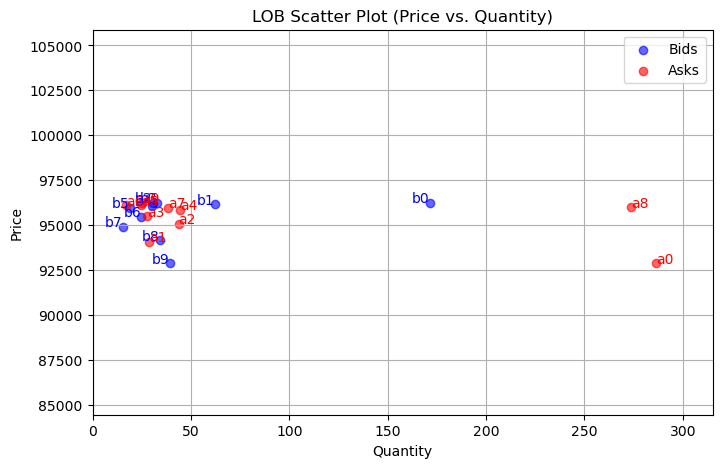

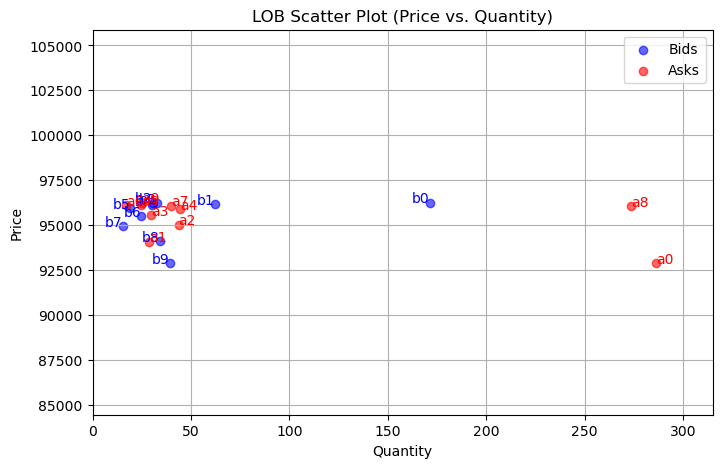

In [ ]:
faulty_rates_mindis = np.array([compute_faulty_rate(tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)) for sample in generated_samples_mindis])

# Plot histogram of faulty rates
plt.figure(figsize=(8, 5))
plt.hist(faulty_rates_mindis, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Faulty Rate")
plt.ylabel("Frequency")
plt.title("Histogram of Faulty Rates in Generated LOB Data")
plt.grid(True)
plt.show()

# Save to CSV
single_lob_sample = generated_samples_mindis[0]  # Choose the first generated sample

# Define column names for LOB structure
lob_columns = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

# Convert to DataFrame
df_single_lob = pd.DataFrame([single_lob_sample], columns=lob_columns)

# Save as CSV
df_single_lob.to_csv("single_generated_lob.csv", index=False)
print("first sample saved to 'single_generated_lob.csv'")

for i in range(5):
    plot_order_book_scatter(generated_samples_mindis[i])